# __1.2. Test save/load checkpoint and determine progress__

Goal:
- Test how checkpoint can be saved and loaded for retraining.
- Get performance information from saved model directories and plot it.

Log:

- 11/21/23
  - Spent another 3 hours trying to figure out what's wrong:
    - Setting resume_from_checkpoint=ckpt_path did not work. The doc said this should be: "local path to a saved checkpoint as saved by a previous instance of Trainer". 
    - Reading more about setting resume_from_checkpoint=True, it said "If a bool and equals True, load the last checkpoint in args.output_dir as saved by a previous instance of Trainer." 
    - The output_dir is also mentioned in the TrainingArgument section as "where the model predictions and checkpoints will be written". In my case, this is the model_dir in the config file which is where the check point folders are located. 
    - Still does not work. Give ValueError: checkpoint_path is not in list.
 - Ok, I found out why.. Should have look into the error message more closely. 
   - Turned out the issue is in the "best_model_checkpoint" value in trainer_state.json. I ran 10 epochs when setting up the dual GPU server and #   has the project directory as:
     - `/home/shiulab/docs_shius/plantbert``
   - But this should be now:
     - `/home/shius/projects/plantbert`
   - Darn... a simple mistake that stumbed me for a week...
- 11/20/23
  - Resume pretraining on 11/17 but get cuda out of memory so the process was killed. This is because I change the batch size from 20 to 21... Change it back.
  - Resume pretraining again using checkpoint-11500. But loss of the next check point rose unexpected before starting to go down rapidly. 
    - [Similar issue](https://github.com/Lightning-AI/lightning/issues/4045) has been reporte.
    - [Another post](https://github.com/huggingface/transformers/issues/23099) with similar issue due to learning rate reset. This is because `trainer.train()` was being called without specify that the passed argument is for `resume_from_checkpoint`. Modified 1_1_bert_retrain_v3 to reflect this.
- 11/17/23
  - Realize that `transformers.Trainer` class already have abstraction to deal with save and load for retrain:
  - E.g., see [this post](https://stackoverflow.com/questions/64663385/saving-and-reload-huggingface-fine-tuned-transformer) for example
  - [Transformer doc on Trainer](https://huggingface.co/docs/transformers/main_classes/trainer)
    - Particularly, look into `train(resume_from_checkpoint=XXX)`
  - So the pytorch-based info is not as useful. See below.

## ___Setup___

In [2]:
import torch, yaml, tarfile, json
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from transformers import BertTokenizerFast, BertConfig, BertForMaskedLM, \
                         DataCollatorForLanguageModeling, TrainingArguments, \
                         Trainer
from tokenizers import BertWordPieceTokenizer
from torchinfo import summary

## ___Pytorch save/load___

[Tutorial on saving/loading checkpoint](
https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html)

### Background

To save multiple checkpoints, you must
- organize them in a dictionary
- use `torch.save()` to serialize the dictionary

A common PyTorch convention is to:
- save these checkpoints using the `.tar`` file extension.
- load the items by:
  - initialize the model and optimizer
  - load the dictionary locally using `torch.load()`
  - access the saved items by simply querying the dictionary as you would expect.

### Steps

1. Import all necessary libraries for loading our data
1. Define and initialize the neural network
1. Initialize the optimizer
1. Save the general checkpoint
1. Load the general checkpoint

#### Define and initialize the neural network

In [2]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### Initialize the optimizer

In [3]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### Save the general checkpoint

In [4]:
EPOCH = 5
PATH = "model.pt"
LOSS = 0.4

torch.save({'epoch': EPOCH,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

#### Load the general checkpoint

In [5]:
# Intialize model and optimizer first
model     = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Load checkpoint
checkpoint = torch.load(PATH)

# Load model state dict, optimizer, epoch, and loss
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [6]:
model.train()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Play with my own model

### Load the general checkpoint

Three steps skipped
- Define and initialize the neural network
- Initialize the optimizer
- Save the general checkpoint

- [how to continue training from a checkpoint with Trainer?](https://github.com/huggingface/transformers/issues/7198)
  - __Ok, none of the following is necessary.__
  - Just do: `trainer.train(checkpoint-dir)`

In [3]:
work_dir  = Path("/home/shius/projects/plantbert/")
model_dir = work_dir / "models"
ckpt_dir  = model_dir / "checkpoint-11500" 

config_file = "./config.yaml"

with open(config_file, 'r') as f:
  config = yaml.safe_load(f)

In [4]:
# Cannot just load the model by pointing out what the directory is 
#checkpoint = torch.load(ckpt_dir)

In [5]:
# initialize the model with the config
vocab_size   = config['tokenize']['vocab_size']
max_length   = config['tokenize']['max_length']
model_config = BertConfig(vocab_size=vocab_size, 
                          max_position_embeddings=max_length)

model = BertForMaskedLM(config=model_config)

In [8]:
optimizer = torch.load(ckpt_dir / "optimizer.pt")
optimizer.keys()

dict_keys(['state', 'param_groups'])

In [ ]:
# Intialize model and optimizer first
model     = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Load checkpoint
checkpoint = torch.load(PATH)

# Load model state dict, optimizer, epoch, and loss
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
model.train()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## ___Determine progress using checkpoints___

In each checkpoint folder, there is a `trainer_state.json` file with info on:
- `epoch`
- `global step`
- `eval_steps`
- `log_history`: point to a list of dictionaries:
  - Traing dictionary with keys: 
    - `epoch`
    - `learning_rate``
    - `loss`
  - Evaluation dictionary:
    - `epoch`
    - `eval_loss`
  - Then the next traing/eval dicts of the next `epoch` value

### Setup

In [3]:
work_dir  = Path.home() / "projects/plantbert"
model_dir = work_dir / "models/"               # compressed ckpt folders
ckpt_dir  = model_dir / "checkpoint-28000"     # ckpt folder

### Parse `trainer_state.json`

- [Python tarfile doc](https://docs.python.org/3/library/tarfile.html)
- [Extract specific file from tar](https://stackoverflow.com/questions/35865099/python-extracting-specific-files-with-pattern-from-tar-gz-without-extracting-th)
- [Convert JSON to dictionary](https://www.geeksforgeeks.org/convert-json-to-dictionary-in-python/#)

In [4]:
log_dict = {} # {epoch: {train: loss, eval: loss}}

# extract file, note that this will be extracted to where the path was
# when the file is tarred. So, this is not right in the directory
# specified.
ts_file = ckpt_dir / "trainer_state.json"

# load json into a dictionary
trainer_state = json.load(open(ts_file, "r"))

# In the loaded dictionary, the key log_history points to a list with
#   training info in the odd elements,
#   evaluation info in the even elements.
for idx, log in enumerate(trainer_state["log_history"]):
  epoch = log['epoch']
  if idx % 2 == 0:
    loss = log['loss']
    log_dict[epoch] = {"train": loss}
  else:
    loss = log['eval_loss']
    log_dict[epoch]["eval"] = loss
    

In [5]:
log_df = pd.DataFrame.from_dict(log_dict, orient="index")
log_df.shape, log_df.head()

((56, 2),
        train      eval
 0.42  6.8941  6.440032
 0.84  6.3389  6.178537
 1.27  6.0998  5.932383
 1.69  5.8730  5.685898
 2.11  5.6051  5.223325)

### Plot losses

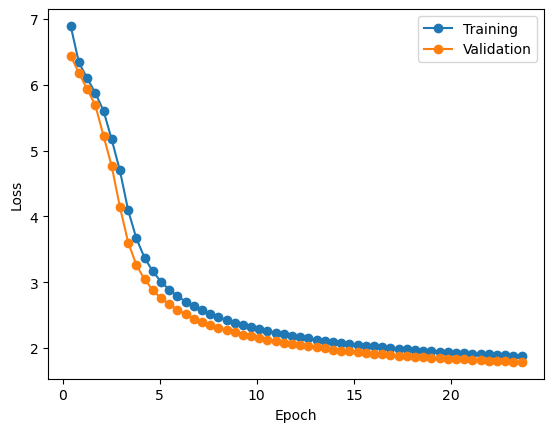

In [6]:
fig, ax = plt.subplots()
ax.plot(log_df.index, log_df["train"], marker="o", label="Training")
ax.plot(log_df.index, log_df["eval"], marker="o", label="Validation")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

plt.savefig(model_dir / "loss.pdf")